# Mario Kart AI

Inspired by [TensorKart](https://github.com/kevinhughes27/TensorKart)

Scripts:
- [record.py](scripts/record.py)
- [utils.py](scripts/utils.py)
    - load_sample
    - viewer
    - prepare
    - ...
- [train.py](scripts/train.py)
- [play.py](scripts/play.py)
- [debugging.ipynb](scripts/debugging.ipynb)

## Play around with recorded data

In [31]:
# function changed to take into account the specificity of the sample 2021-02-27-1 
def load_sample(sample):
    image_files = np.loadtxt(sample + '/data.csv', delimiter=',', dtype=str, usecols=(0,))
    image_files = [f.replace('samples','samples/2021-02-27-1') for f in image_files] # added this line
    joystick_values = np.loadtxt(sample + '/data.csv', delimiter=',', usecols=(1,2,3,4,5))
    return image_files, joystick_values


The samples had not originally been stored in a dedicated folder (with the name of day of recording, and the number of recording)

In [38]:
import numpy as np
image_files, joystick_values = load_sample('samples/2021-02-27-1')
image_files[48],joystick_values[48]

('samples/2021-02-27-1/img_48.png',
 array([-0.48028564, -0.05511475,  1.        ,  0.        ,  0.        ]))

3   [ 0.         -0.01574707  1.          0.          0.        ]


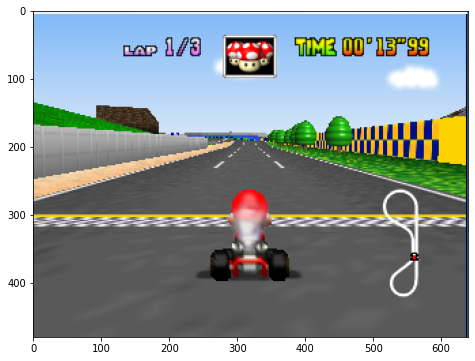

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_files, joystick_values = load_sample('samples/2021-02-27-1')

plt.ion()
plt.figure('viewer', figsize=(16, 6))

# for i in range(len(image_files)):
i=3
# joystick
print(i, " ", joystick_values[i,:])

# image (every 3rd)

image_file = image_files[i]
img = mpimg.imread(image_file)
plt.imshow(img)


-0.0157470703125


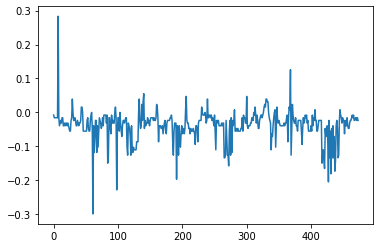

In [7]:
# Plot joystick y values

print(joystick_values[3,1])

plt.plot(joystick_values[:,1])

## Prepare Data

In [11]:
import pandas as pd
data = pd.DataFrame({'center':image_files,'steering': joystick_values[:,1]})
data

,center,steering
0,samples/2021-02-27-1/img_0.png,-0.007874
1,samples/2021-02-27-1/img_1.png,-0.015747
2,samples/2021-02-27-1/img_2.png,-0.015747
3,samples/2021-02-27-1/img_3.png,-0.015747
4,samples/2021-02-27-1/img_4.png,-0.015747
...,...,...
469,samples/2021-02-27-1/img_469.png,-0.015747
470,samples/2021-02-27-1/img_470.png,-0.015747
471,samples/2021-02-27-1/img_471.png,-0.023621
472,samples/2021-02-27-1/img_472.png,-0.015747


total data: 474


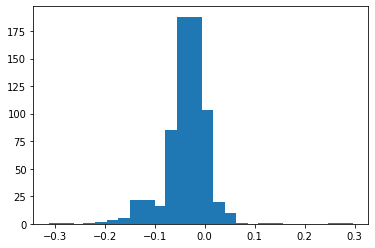

In [13]:
num_bins = 25
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
print('total data:', len(data))

In [17]:
image_paths = data['center']
steerings = data['steering']

In [18]:
# from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 379
Valid Samples: 95


Text(0.5, 1.0, 'Validation set')

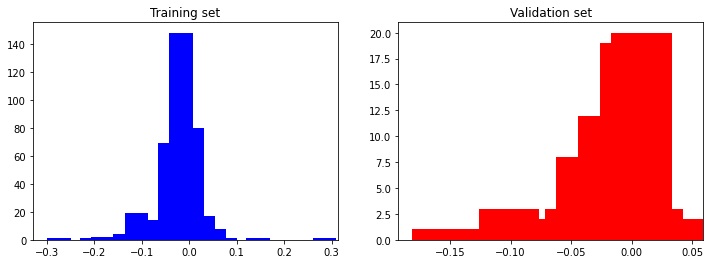

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

## Preprocess Images

In [30]:
class Sample:
    IMG_W = 200
    IMG_H = 66
    IMG_D = 3

# Global variable
OUT_SHAPE = 5
INPUT_SHAPE = (Sample.IMG_H, Sample.IMG_W, Sample.IMG_D)

In [40]:
from skimage.transform import resize
from skimage.io import imread

In [41]:
def resize_image(img):
    im = resize(img, (Sample.IMG_H, Sample.IMG_W, Sample.IMG_D))
    im_arr = im.reshape((Sample.IMG_H, Sample.IMG_W, Sample.IMG_D))
    return im_arr

In [42]:
# prepare training data
def prepare(samples):
    print("Preparing data")

    X = []
    y = []

    for sample in samples:
        print(sample)

        # load sample
        image_files, joystick_values = load_sample(sample)

        # add joystick values to y
        y.append(joystick_values)

        # load, prepare and add images to X
        for image_file in image_files:
            image = imread(image_file)
            vec = resize_image(image)
            X.append(vec)

    print("Saving to file...")
    X = np.asarray(X)
    y = np.concatenate(y)

    np.save("data/X", X)
    np.save("data/y", y)

    print("Done!")
    return

In [47]:
prepare(['samples/2021-02-27-1'])

Preparing data
samples/2021-02-27-1
Saving to file...
Done!


## Train model

In [48]:
x_train = np.load("data/X.npy")
y_train = np.load("data/y.npy")

print(x_train.shape[0], 'train samples')

474 train samples


(66, 200, 3)


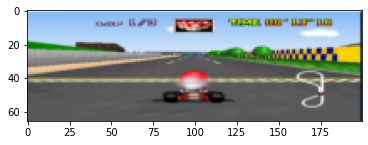

In [49]:
print(x_train[0].shape)
plt.imshow(x_train[0])

In [55]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
# from keras import optimizers
from keras import backend as K


In [51]:
def create_model(keep_prob = 0.8):
    model = Sequential()

    # NVIDIA's model
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), activation='relu', input_shape= INPUT_SHAPE))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    drop_out = 1 - keep_prob
    model.add(Dropout(drop_out))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(drop_out))
    model.add(Dense(OUT_SHAPE, activation='softsign'))

    return model

In [52]:
def customized_loss(y_true, y_pred, loss='euclidean'):
    # Simply a mean squared error that penalizes large joystick summed values
    if loss == 'L2':
        L2_norm_cost = 0.001
        val = K.mean(K.square((y_pred - y_true)), axis=-1) \
                    + K.sum(K.square(y_pred), axis=-1)/2 * L2_norm_cost
    # euclidean distance loss
    elif loss == 'euclidean':
        val = K.sqrt(K.sum(K.square(y_pred-y_true), axis=-1))
    return val

In [64]:
# Training loop variables
epochs = 100
batch_size = 50

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1164)             

In [65]:
model.compile(loss=customized_loss, optimizer=Adam())
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=0.1)

Epoch 1/100
9/9 [==============================] - 3s 247ms/step - loss: 0.8931 - val_loss: 0.7441
Epoch 2/100
9/9 [==============================] - 2s 207ms/step - loss: 0.8325 - val_loss: 0.7312
Epoch 3/100
9/9 [==============================] - 2s 195ms/step - loss: 0.8146 - val_loss: 0.7128
Epoch 4/100
9/9 [==============================] - 2s 221ms/step - loss: 0.7858 - val_loss: 0.6947
Epoch 5/100
9/9 [==============================] - 2s 201ms/step - loss: 0.7783 - val_loss: 0.6792
Epoch 6/100
9/9 [==============================] - 2s 214ms/step - loss: 0.7505 - val_loss: 0.6625
Epoch 7/100
9/9 [==============================] - 2s 199ms/step - loss: 0.7452 - val_loss: 0.6427
Epoch 8/100
9/9 [==============================] - 2s 226ms/step - loss: 0.7202 - val_loss: 0.6289
Epoch 9/100
9/9 [==============================] - 2s 198ms/step - loss: 0.6917 - val_loss: 0.6181
Epoch 10/100
9/9 [==============================] - 2s 211ms/step - loss: 0.6722 - val_loss: 0.5970
Epoch 11/

In [66]:
model.save_weights('models/model_weights_2021-02-27-1_100epochs.h5')

Text(0.5, 0, 'Epoch')

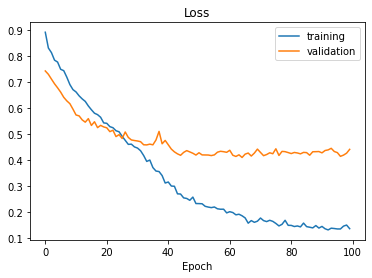

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

## Load model

In [81]:
import os
os.chdir('scripts')
from train import create_model
model = create_model(keep_prob=1)
os.chdir('..')

In [82]:
model.load_weights("models/model_weights_2021-02-27-1_100epochs.h5")

## Test model

In [83]:
# x_train[0].shape
vec = np.expand_dims(x_train[0], axis=0) # expand dimensions for predict, it wants (1,66,200,3) not (66, 200, 3)
model.predict(vec)

array([[-0.01662593, -0.04622109,  0.97038376, -0.01899318,  0.0026027 ]],
      dtype=float32)

[ 0.         -0.00787354  0.          0.          0.        ]


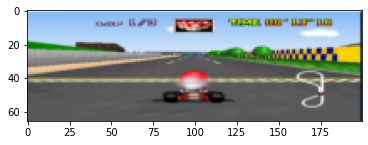

In [84]:
print(y_train[0])
plt.imshow(x_train[0])